## Import dependencies

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot, plot
import plotly.express as px
from scipy.stats import norm, kurtosis
from scipy.signal import butter, lfilter, freqz
from scipy import signal
from sklearn.model_selection import train_test_split
from collections import Counter

import glob
import os

plt.rcParams["figure.figsize"] = 16,10


from processing_funcs import *

## Read data

In [67]:
df = read_all()

In [68]:
df.head()

,time,lat,lon,height,velocity,direction,h_accuracy,v_accuracy,id_gps,x_lin_acc,y_lin_acc,z_lin_acc,x_gyro,y_gyro,z_gyro,x_acc,y_acc,z_acc,label
14,0.14,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,1,-0.068991,0.116175,-0.231500,-0.010804,0.001345,-0.033967,0.010029,-0.066162,9.487570,0
15,0.15,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,1,0.119553,0.105636,-0.053966,0.001346,0.008800,-0.035701,-0.054936,-0.025597,9.624087,0
16,0.16,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,1,0.013766,-0.061842,-0.085847,-0.007075,0.005302,-0.027966,0.181722,-0.081730,9.736653,0
17,0.17,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,1,0.063374,0.128633,-0.271607,-0.007945,0.006663,-0.028829,0.057930,-0.128134,9.693692,0
18,0.18,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,1,0.089934,0.096254,-0.355428,-0.004748,-0.002140,-0.035702,0.103884,-0.026944,9.488020,0


## Groupping Data

In order to see how many data points belongs to eachy gps datapoint, we can group the data regarding to the `id_gps` and the `label` column.

In [69]:
agg_df = df.groupby(["label","id_gps"]).count()
agg_df.head()

time  lat  lon  height  velocity  direction  h_accuracy  \
label id_gps                                                            
0     1        163  163  163     163       163        163         163   
      2        100  100  100     100       100        100         100   
      3        100  100  100     100       100        100         100   
      4        100  100  100     100       100        100         100   
      5        100  100  100     100       100        100         100   

              v_accuracy  x_lin_acc  y_lin_acc  z_lin_acc  x_gyro  y_gyro  \
label id_gps                                                                
0     1              163        163        163        163     163     163   
      2              100        100        100        100     100     100   
      3              100        100        100        100     100     100   
      4              100        100        100        100     100     100   
      5              100        100        100        100     100     100   

              z_gyro  x_acc  y_acc  z_acc  
label id_gps                               
0     1          163    163    163    163  
      2          100    100    100    100  
      3          100    100    100    100  
      4          100    100    100    100  
      5          100    100    100    100

### Representing the number of datapoints / gps data

We need to do some data transformation, to get the data in a form which can be plotted.

In [70]:
agg_df.reset_index(inplace=True)

In [71]:
agg_df = agg_df[["label","id_gps","time"]]

In [72]:
agg_df.columns = ["label","id_gps","count"]
agg_df.head()

,label,id_gps,count
0,0,1,163
1,0,2,100
2,0,3,100
3,0,4,100
4,0,5,100


Text(0, 0.5, 'Frequenzy')

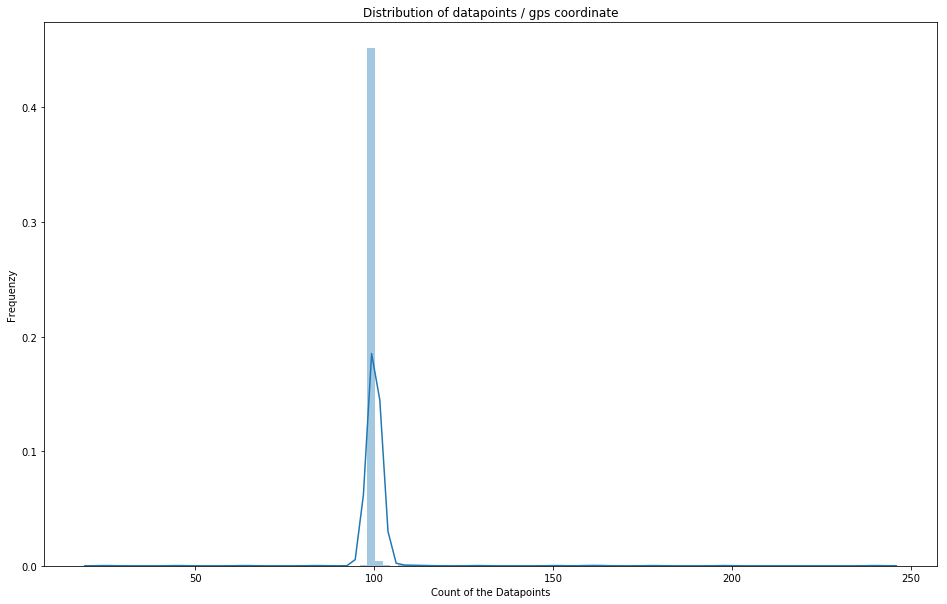

In [73]:
sns.distplot(agg_df["count"], 100)
plt.title("Distribution of datapoints / gps coordinate")
plt.xlabel("Count of the Datapoints")
plt.ylabel("Frequenzy")

The data point are equally distributed

### Prepare data

In [91]:
def butter_high(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_high_filter(data, cutoff, fs, order=5):
    b, a = butter_high(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [92]:
df.columns

Index(['time', 'lat', 'lon', 'height', 'velocity', 'direction', 'h_accuracy',
       'v_accuracy', 'id_gps', 'x_lin_acc', 'y_lin_acc', 'z_lin_acc', 'x_gyro',
       'y_gyro', 'z_gyro', 'x_acc', 'y_acc', 'z_acc', 'label'],
      dtype='object')

In [95]:
def filter_acc(df, cutoff=2, fs=50, order=2):

    signals = [ 'x_lin_acc', 'y_lin_acc', 'z_lin_acc','x_acc', 'y_acc', 'z_acc',]

    new_df = pd.DataFrame(columns=signals)

    for label in df.label.unique():

        label_df = df[df.label == label]

        list_signals = []

        for j in signals:

            filtered_signal = butter_high_filter(label_df[j], cutoff=cutoff, fs=fs, order=order)

            list_signals.append(filtered_signal)

        new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=signals)])

    return new_df

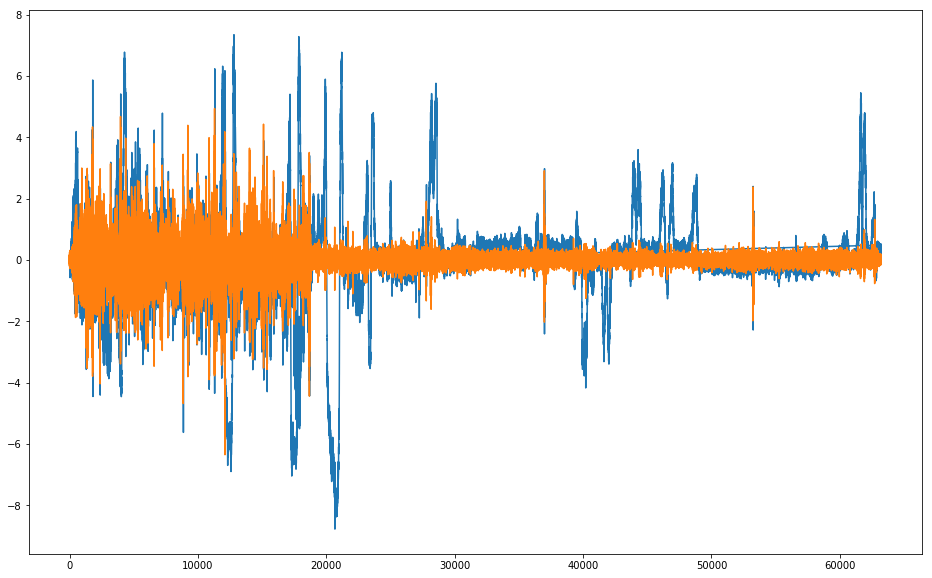

In [96]:
df["x_acc"].plot()
filter_acc(df)["x_acc"].plot()

In [12]:
def filter_gyro(df, cutoff=10, fs=50, order=2):

    signals = ['x_gyro', 'y_gyro', 'z_gyro']

    new_df = pd.DataFrame(columns=signals)

    for label in df.label.unique():

        label_df = df[df.label == label]

        list_signals = []

        for j in signals:

            filtered_signal = butter_high_filter(label_df[j], cutoff=cutoff, fs=fs, order=order)

            list_signals.append(filtered_signal)

        new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=signals)])

    return new_df

In [103]:
df.drop(filter_acc(df).columns,axis=1)

,time,lat,lon,height,velocity,direction,h_accuracy,v_accuracy,id_gps,x_gyro,y_gyro,z_gyro,label
14,0.14,47.696266,17.726061,118.349480,-1.000000,-1.000000,418.967358,418.967358,1,-0.010804,0.001345,-0.033967,0
15,0.15,47.696266,17.726061,118.349480,-1.000000,-1.000000,418.967358,418.967358,1,0.001346,0.008800,-0.035701,0
16,0.16,47.696266,17.726061,118.349480,-1.000000,-1.000000,418.967358,418.967358,1,-0.007075,0.005302,-0.027966,0
17,0.17,47.696266,17.726061,118.349480,-1.000000,-1.000000,418.967358,418.967358,1,-0.007945,0.006663,-0.028829,0
18,0.18,47.696266,17.726061,118.349480,-1.000000,-1.000000,418.967358,418.967358,1,-0.004748,-0.002140,-0.035702,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12875,128.75,47.694844,17.675054,117.642292,11.712904,85.817919,6.000906,6.000906,129,0.027666,-0.029211,-0.012400,2
12876,128.76,47.694844,17.675054,117.642292,11.712904,85.817919,6.000906,6.000906,129,0.035673,-0.008810,-0.015961,2
12877,128.77,47.694844,17.675054,117.642292,11.712904,85.817919,6.000906,6.000906,129,0.041637,0.014038,-0.008203,2
12878,128.78,47.694844,17.675054,117.642292,11.712904,85.817919,6.000906,6.000906,129,0.061041,0.035687,0.000275,2


In [112]:
filtered_df = filter_acc(df)
filtered_df.shape

(94893, 6)

In [115]:
new_df = df.drop(filtered_df.columns, axis=1)

In [120]:
df = pd.concat([new_df.reset_index(),filtered_df.reset_index()], axis=1)

In [121]:
def kurtosis_time(x):

    return kurtosis(x, fisher=True)

def rms_100(x):

    return np.sqrt(np.mean(x**2))

def crest(x):

    return max(abs(x))/np.sqrt(np.mean(x**2))

def create_aggregated(df):
    """Create a aggregated dataframe in time domain"""
    signals = ['x_lin_acc', 'y_lin_acc', 
               'x_acc', 'y_acc', 'z_acc',
               'x_gyro', 'y_gyro', 'z_gyro']

    agg_df = df.groupby(["label", "id_gps"]).agg({x: ["sum", "mean", "mad",
                                                "median", "min", "max",
                                                "std", "var", "sem",
                                                "skew", "quantile",
                                                kurtosis_time, rms_100,
                                                crest] for x in signals})

    return agg_df

In [122]:
feature_df = create_aggregated(df).reset_index()

In [123]:
feature_df.head()

label id_gps x_lin_acc                                                    \
                     sum      mean       mad    median       min       max   
0     0      1 -0.001147 -0.000007  0.068877  0.001584 -0.191238  0.181386   
1     0      2  0.014295  0.000143  0.081140 -0.005277 -0.184262  0.271685   
2     0      3  0.086871  0.000869  0.080640  0.000047 -0.311881  0.322584   
3     0      4 -0.183500 -0.001835  0.084659  0.001246 -0.379503  0.233228   
4     0      5  0.127569  0.001276  0.068525  0.012833 -0.304641  0.239552   

                       ...    z_gyro                                          \
        std       var  ...       min       max       std       var       sem   
0  0.083427  0.006960  ... -0.038407  0.019060  0.020960  0.000439  0.001642   
1  0.099228  0.009846  ...  0.004437  0.026998  0.004069  0.000017  0.000407   
2  0.102942  0.010597  ...  0.005714  0.026547  0.004525  0.000020  0.000452   
3  0.110712  0.012257  ... -0.026722  0.029607  0.012857  0.000165  0.001286   
4  0.087711  0.007693  ... -0.021767 -0.002582  0.003297  0.000011  0.000330   

                                                         
       skew  quantile kurtosis_time   rms_100     crest  
0 -0.245129  0.004298     -1.747767  0.021991  1.746537  
1  0.358179  0.014297      0.330516  0.015283  1.766488  
2  0.100271  0.015716     -0.303948  0.016737  1.586147  
3  1.935585 -0.019049      2.478354  0.018980  1.559952  
4  0.002201 -0.012527      0.552075  0.013161  1.653923  

[5 rows x 114 columns]

## Shuffle Data

In [124]:
from sklearn.model_selection import train_test_split

In [125]:
X = feature_df.drop(["label"], axis=1)
y = feature_df["label"]

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [126]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2, 
                                                  random_state=42,
                                                  shuffle = True)

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle =  True)

In [128]:
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)
print("y_test: ", y_test.shape)

X_train:  (604, 113)
X_val:  (189, 113)
X_test:  (152, 113)
y_train:  (604,)
y_val:  (189,)
y_test:  (152,)


Checking the number of the labels in the train, validation and test datasets.

In [129]:
print("Number of label for each label in the train dataset: {}".format(Counter(y_train).most_common()))
print("Number of label for each label in the validation dataset: {}".format(Counter(y_val).most_common()))
print("Number of label for each label in the validation dataset: {}".format(Counter(y_test).most_common()))

Number of label for each label in the train dataset: [(0, 399), (1, 126), (2, 79)]
Number of label for each label in the validation dataset: [(0, 131), (1, 30), (2, 28)]
Number of label for each label in the validation dataset: [(0, 101), (1, 30), (2, 21)]


##  Prepare for ML

In [130]:
feature_df.columns

MultiIndex([(    'label',              ''),
            (   'id_gps',              ''),
            ('x_lin_acc',           'sum'),
            ('x_lin_acc',          'mean'),
            ('x_lin_acc',           'mad'),
            ('x_lin_acc',        'median'),
            ('x_lin_acc',           'min'),
            ('x_lin_acc',           'max'),
            ('x_lin_acc',           'std'),
            ('x_lin_acc',           'var'),
            ...
            (   'z_gyro',           'min'),
            (   'z_gyro',           'max'),
            (   'z_gyro',           'std'),
            (   'z_gyro',           'var'),
            (   'z_gyro',           'sem'),
            (   'z_gyro',          'skew'),
            (   'z_gyro',      'quantile'),
            (   'z_gyro', 'kurtosis_time'),
            (   'z_gyro',       'rms_100'),
            (   'z_gyro',         'crest')],
           length=114)

In [131]:
feature_df.drop(["label"], axis=1).columns

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



MultiIndex([(   'id_gps',              ''),
            ('x_lin_acc',           'sum'),
            ('x_lin_acc',          'mean'),
            ('x_lin_acc',           'mad'),
            ('x_lin_acc',        'median'),
            ('x_lin_acc',           'min'),
            ('x_lin_acc',           'max'),
            ('x_lin_acc',           'std'),
            ('x_lin_acc',           'var'),
            ('x_lin_acc',           'sem'),
            ...
            (   'z_gyro',           'min'),
            (   'z_gyro',           'max'),
            (   'z_gyro',           'std'),
            (   'z_gyro',           'var'),
            (   'z_gyro',           'sem'),
            (   'z_gyro',          'skew'),
            (   'z_gyro',      'quantile'),
            (   'z_gyro', 'kurtosis_time'),
            (   'z_gyro',       'rms_100'),
            (   'z_gyro',         'crest')],
           length=113)

In [132]:
if not os.path.exists("../data/train_test_val"):
        os.makedirs("../data/train_test_val")

cols = feature_df.drop(["label"], axis=1).columns
        
pd.DataFrame(X_train, columns=cols).to_csv( "../data/train_test_val/X_train.csv")
pd.DataFrame(X_val, columns=cols).to_csv("../data/train_test_val/X_val.csv")
pd.DataFrame(X_test, columns=cols).to_csv("../data/train_test_val/X_test.csv")
        
pd.DataFrame(y_train).to_csv( "../data/train_test_val/y_train.csv")
pd.DataFrame(y_val).to_csv("../data/train_test_val/y_val.csv")
pd.DataFrame(y_test).to_csv("../data/train_test_val/y_test.csv")

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [133]:
pd.read_csv("../data/train_test_val/X_test.csv", header=[0,1], index_col=0)

id_gps x_lin_acc                                          \
    Unnamed: 1_level_1       sum      mean       mad    median       min   
480                481  0.033925  0.000339  0.086399 -0.006998 -0.268123   
404                405 -0.292003 -0.002920  0.117746 -0.014059 -0.272058   
898                 83  0.820973  0.008210  0.561902  0.040289 -1.380037   
95                  96  0.067995  0.000680  0.117231 -0.003127 -0.378902   
612                613 -0.322062 -0.003221  0.130006 -0.007159 -0.450410   
..                 ...       ...       ...       ...       ...       ...   
74                  75 -0.180592 -0.001806  0.104263 -0.004030 -0.245515   
748                118  0.176512  0.001765  0.583065  0.001216 -3.038045   
580                581 -0.315352 -0.003154  0.096920  0.016648 -0.360266   
309                310  0.141837  0.001418  0.145529 -0.000321 -0.360965   
624                625  0.466970  0.004670  0.127697 -0.004188 -0.429868   

                                             ...    z_gyro            \
          max       std       var       sem  ...       min       max   
480  0.216029  0.105145  0.011055  0.010514  ... -0.032631  0.005547   
404  0.341927  0.144802  0.020968  0.014480  ...  0.018253  0.042696   
898  2.140255  0.715555  0.512019  0.071555  ... -0.030897  0.046439   
95   0.355280  0.148675  0.022104  0.014867  ...  0.035935  0.054452   
612  0.410814  0.165117  0.027264  0.016512  ... -0.103352 -0.057540   
..        ...       ...       ...       ...  ...       ...       ...   
74   0.358149  0.125821  0.015831  0.012582  ...  0.003664  0.019820   
748  2.949946  0.902439  0.814396  0.090244  ... -0.085872  0.049434   
580  0.298988  0.117931  0.013908  0.011793  ... -0.007842  0.005992   
309  0.492907  0.176051  0.030994  0.017605  ...  0.008117  0.030793   
624  0.555402  0.160929  0.025898  0.016093  ... -0.132343 -0.024125   

                                                                               \
          std       var       sem      skew  quantile kurtosis_time   rms_100   
480  0.012025  0.000145  0.001203 -0.176589 -0.009717     -1.479753  0.017225   
404  0.005182  0.000027  0.000518 -0.076828  0.030318     -0.585619  0.030427   
898  0.015144  0.000229  0.001514  0.190555  0.005257     -0.215529  0.016561   
95   0.004392  0.000019  0.000439  0.704209  0.042268     -0.087299  0.043275   
612  0.008238  0.000068  0.000824 -0.618811 -0.078096      1.165296  0.079157   
..        ...       ...       ...       ...       ...           ...       ...   
74   0.003295  0.000011  0.000329  0.117293  0.011214     -0.232718  0.011762   
748  0.022888  0.000524  0.002289 -0.755753 -0.009370      1.853259  0.025697   
580  0.003060  0.000009  0.000306 -0.214415  0.000039     -0.477706  0.003056   
309  0.004590  0.000021  0.000459 -0.526085  0.021222      0.241007  0.021663   
624  0.029133  0.000849  0.002913 -0.699380 -0.064197     -0.603187  0.077203   

               
        crest  
480  1.894413  
404  1.403234  
898  2.804195  
95   1.258268  
612  1.305657  
..        ...  
74   1.685066  
748  3.341781  
580  2.565942  
309  1.421430  
624  1.714223  

[152 rows x 113 columns]